#Install Pyspark#

In [2]:
!pip install pyspark

#Task 1#

####Use RDD of PySpark library to read baskets.csv. Then implement, execute, save, and visualize results of the following functions.####

In [3]:
import pyspark
import pandas as pd
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
import os

In [38]:

def f1(baskets_path):
    spark = SparkSession.builder.appName("ListProduct").getOrCreate()
    rdd = spark.sparkContext.textFile(baskets_path)

    # Delete header, choose column product, convert to uppercase, check duplicated, sort products
    products_rdd = rdd.zipWithIndex() \
                      .filter(lambda x: x[1] > 0) \
                      .map(lambda x: x[0].split(",")[2].upper()) \
                      .distinct() \
                      .sortBy(lambda x: x)

    # Print first and last 10 items
    first_10_products = products_rdd.take(10)
    last_10_products = products_rdd.top(10)[::-1]

    print("First 10 Products:", first_10_products)
    print("Last 10 Products:", last_10_products)

    # Save to folder
    save_path = "/content/f1"  # Updated save path to use the mounted data folder
    with open(f"{save_path}/results.txt", "w") as f:
        f.write("First 10 Products:\n")
        f.write('\n'.join(first_10_products))
        f.write("\n\nLast 10 Products:\n")
        f.write('\n'.join(last_10_products))

    spark.stop()


In [39]:
f1("/baskets.csv")

First 10 Products: ['ABRASIVE CLEANER', 'ARTIF. SWEETENER', 'BABY COSMETICS', 'BAGS', 'BAKING POWDER', 'BATHROOM CLEANER', 'BEEF', 'BERRIES', 'BEVERAGES', 'BOTTLED BEER']
Last 10 Products: ['UHT-MILK', 'VINEGAR', 'WAFFLES', 'WHIPPED/SOUR CREAM', 'WHISKY', 'WHITE BREAD', 'WHITE WINE', 'WHOLE MILK', 'YOGURT', 'ZWIEBACK']


In [14]:

def f2(baskets_path):
    spark = SparkSession.builder.appName("ProductFrequency").getOrCreate()
    rdd = spark.sparkContext.textFile(baskets_path)

    header = rdd.first()
    product_freq_rdd = (rdd.filter(lambda x: x != header)
                          .map(lambda x: x.split(",")[2])
                          .map(lambda product: (product, 1))
                          .reduceByKey(lambda a, b: a + b)
                          .sortBy(lambda pair: pair[1], ascending=False))

    top_100_products = product_freq_rdd.take(100)
    for products, frequencies in top_100_products:
        print(f"{products}: {frequencies}")
    spark.stop()

    products, frequencies = zip(*top_100_products)

    # Draw a bar chart
    plt.figure(figsize=(20, 10))
    plt.bar(products, frequencies, color='skyblue')
    plt.xlabel('Products')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)  # Rotate the product names to show them better
    plt.title('Top 100 Products by Purchase Frequency')
    plt.tight_layout()  # Adjust layout to fit all product names

    # Save the plot
    plot_save_path = "/content/f2/top_100_products_chart.png"
    plt.savefig(plot_save_path)
    plt.show()

    # Save the data
    data_save_path = "/content/f2/top_100_products_data.txt"
    with open(data_save_path, "w") as file:
        for product, frequency in top_100_products:
            file.write(f"{product}: {frequency}\n")

whole milk: 2502
other vegetables: 1898
rolls/buns: 1716
soda: 1514
yogurt: 1334
root vegetables: 1071
tropical fruit: 1032
bottled water: 933
sausage: 924
citrus fruit: 812
pastry: 785
pip fruit: 744
shopping bags: 731
canned beer: 717
bottled beer: 687
whipped/sour cream: 662
newspapers: 596
frankfurter: 580
brown bread: 571
domestic eggs: 566
pork: 566
butter: 534
fruit/vegetable juice: 518
beef: 516
curd: 514
margarine: 491
coffee: 476
frozen vegetables: 425
chicken: 422
white bread: 362
cream cheese : 358
chocolate: 357
dessert: 356
napkins: 335
hamburger meat: 327
berries: 327
UHT-milk: 323
onions: 305
salty snack: 283
waffles: 280
long life bakery product: 269
sugar: 265
butter milk: 263
ham: 256
meat: 254
frozen meals: 252
beverages: 251
specialty chocolate: 240
misc. beverages: 238
ice cream: 227
oil: 225
hard cheese: 220
grapes: 220
candy: 219
sliced cheese: 212
specialty bar: 210
hygiene articles: 208
chewing gum: 181
cat food: 177
white wine: 176
herbs: 159
red/blush wine: 

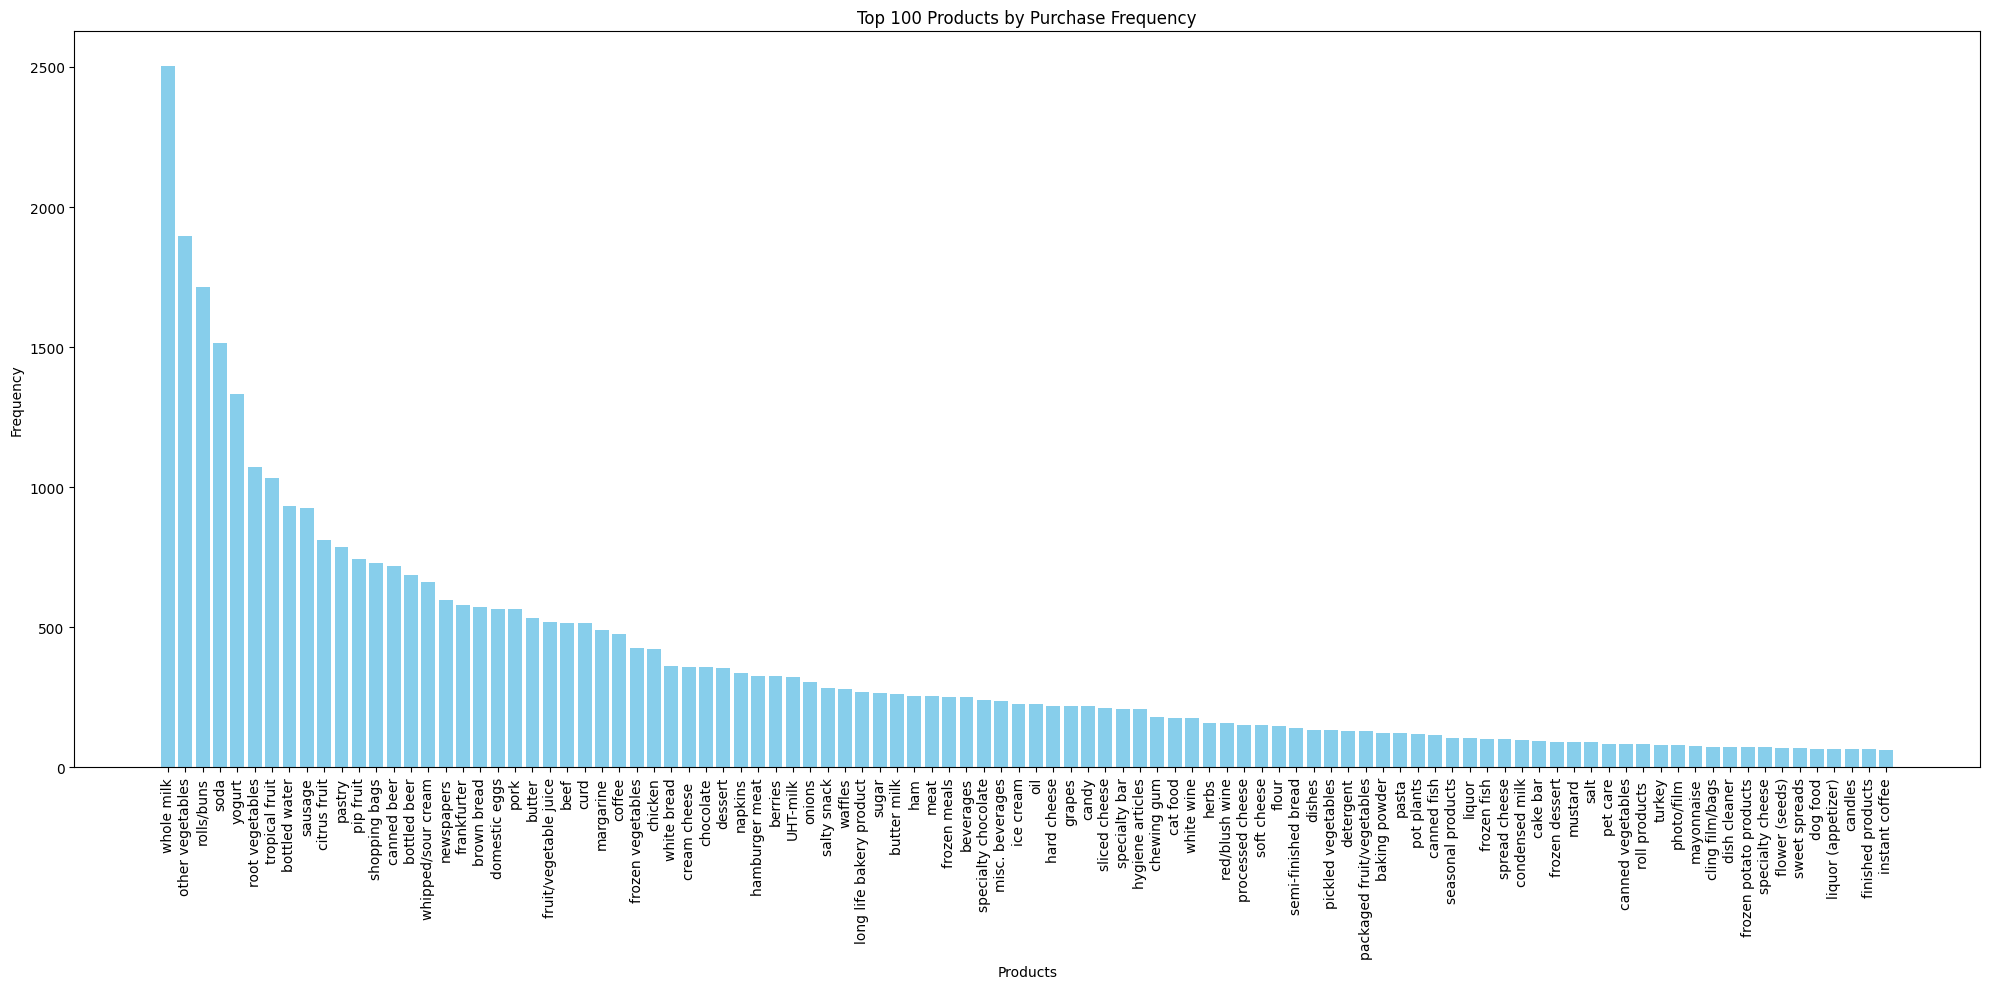

In [15]:
f2("/baskets.csv")

In [40]:

def f3(baskets_path):
    spark = SparkSession.builder.appName("BasketsPerMember").getOrCreate()
    baskets_rdd = spark.sparkContext.textFile(baskets_path)
    header = baskets_rdd.first()
    baskets_data = baskets_rdd \
        .filter(lambda line: line != header).map(lambda line: line.split(','))
    member_basket_rdd = (baskets_data
                         .map(lambda x: ((x[0], x[1]), {x[2]}))
                         .reduceByKey(lambda a, b: a | b)
                         .map(lambda x: (x[0][0], 1))
                         .reduceByKey(lambda a, b: a + b)
                         .sortBy(lambda x: x[1], ascending=False))

    top_100_members = member_basket_rdd.take(100)
    for member, count in top_100_members:
        print(f"{member}: {count}")

    # Ensure the directory exists
    output_dir = 'f3'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    spark.stop()

    # Unpack the members and counts for plotting
    members, counts = zip(*top_100_members)

    # Plot
    plt.figure(figsize=(12, 8))
    plt.bar(range(len(counts)), counts, color='skyblue')
    plt.xlabel("Member IDs")
    plt.ylabel("Number of Baskets")
    plt.title("Top 100 Members by Number of Baskets")
    plt.xticks(range(len(members)), members, rotation=90)
    plt.tight_layout()
    plt.show()
    # Save the plot in the specified directory
    plt.savefig(f"{output_dir}/member_basket_count.png")
    plt.close()  # Close the plot to free memory




2271: 11
1379: 11
4338: 11
3737: 11
2193: 11
1574: 10
4217: 10
2524: 10
2394: 10
4864: 10
3180: 10
3872: 10
1793: 10
3915: 10
3120: 10
4376: 10
1052: 10
1908: 10
3289: 10
3082: 10
3248: 10
1410: 10
3484: 10
2625: 10
1275: 10
3593: 10
2851: 9
3221: 9
4303: 9
1566: 9
3830: 9
4683: 9
1136: 9
1169: 9
4933: 9
3050: 9
2517: 9
2990: 9
2164: 9
1991: 9
4272: 9
3402: 9
4137: 9
3361: 9
1922: 9
4364: 9
2760: 9
1827: 9
3462: 9
2294: 9
2663: 9
3090: 9
1905: 9
1878: 9
3465: 9
4941: 9
1087: 9
1466: 9
1998: 9
2960: 9
4437: 9
2070: 9
3122: 9
4656: 9
2758: 9
4494: 9
1932: 9
2440: 9
2632: 9
4190: 9
1654: 9
3308: 9
4526: 9
4695: 9
4721: 8
4453: 8
1013: 8
4297: 8
4645: 8
3137: 8
3517: 8
2706: 8
1889: 8
4694: 8
2868: 8
3657: 8
4667: 8
1235: 8
2511: 8
2298: 8
4875: 8
3942: 8
1190: 8
3812: 8
2011: 8
4019: 8
3663: 8
4455: 8
1979: 8
2014: 8


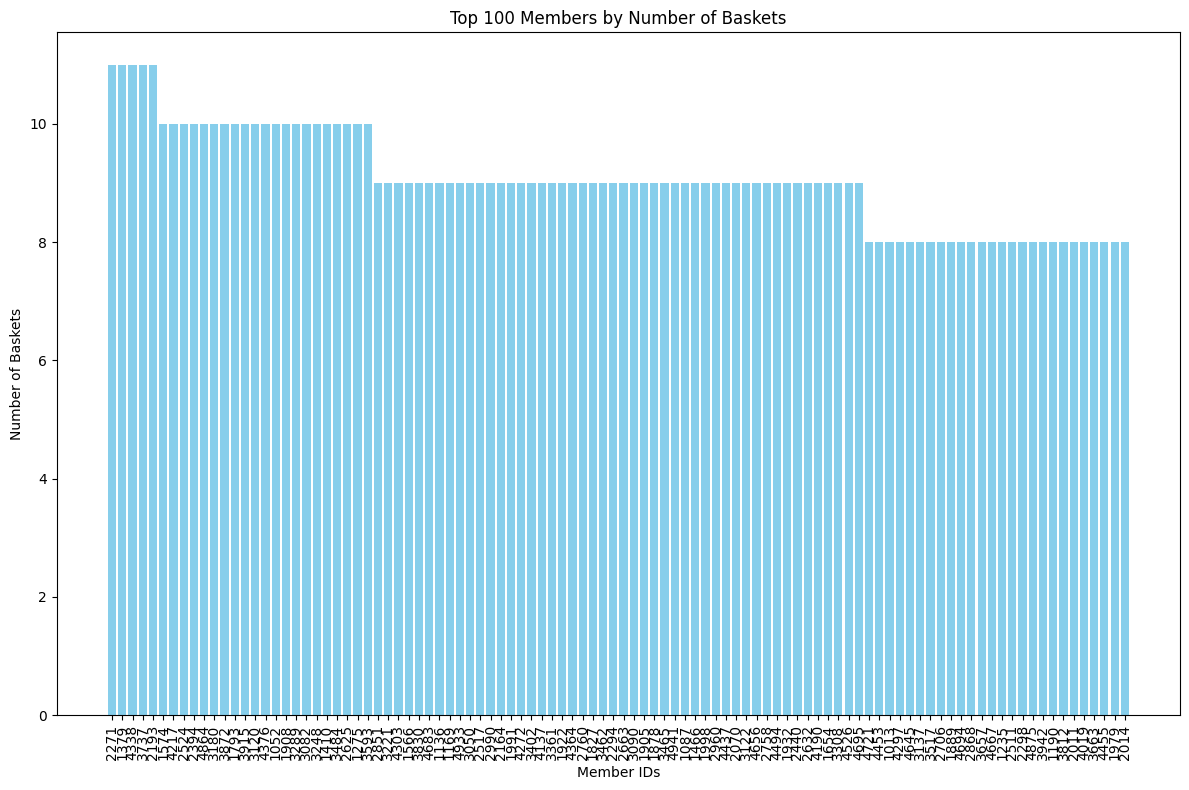

In [41]:
f3("/baskets.csv")

In [31]:

def f4(baskets_path):
    spark = SparkSession.builder.appName("PurchaseAnalysis").getOrCreate()
    baskets_rdd = spark.sparkContext.textFile(baskets_path)
    header = baskets_rdd.first()
    baskets_rdd = baskets_rdd.filter(lambda line: line != header).map(lambda line: line.split(","))

    member_products_rdd = baskets_rdd.map(lambda x: (x[0], x[2])).distinct()
    member_with_most_products = (member_products_rdd
                                 .map(lambda x: (x[0], 1))
                                 .reduceByKey(lambda a, b: a + b)
                                 .sortBy(lambda x: x[1], ascending=False)
                                 .first())

    product_members_rdd = baskets_rdd.map(lambda x: (x[2], x[0])).distinct()
    product_with_most_members = (product_members_rdd
                                 .map(lambda x: (x[0], 1))
                                 .reduceByKey(lambda a, b: a + b)
                                 .sortBy(lambda x: x[1], ascending=False)
                                 .first())

    if not os.path.exists('f4'):
        os.makedirs('f4')
    spark.stop()

    print("Member with the largest number of distinct products:")
    print(f"  ID: {member_with_most_products[0]}")
    print(f"  Number of products: {member_with_most_products[1]}")

    with open('f4/member_with_most_products.txt', 'w') as file:
        file.write(f"{member_with_most_products[0]},{member_with_most_products[1]}")

    print("\nProduct bought by the most members:")
    print(f"  Name products: {product_with_most_members[0]}")
    print(f"  Number of members: {product_with_most_members[1]}")

    with open('f4/product_with_most_members.txt', 'w') as file:
        file.write(f"{product_with_most_members[0]},{product_with_most_members[1]}")

In [17]:
f4("/baskets.csv")

Member with the largest number of distinct products:
  ID: 2051
  Number of products: 26

Product bought by the most members:
  Name products: whole milk
  Number of members: 1786


#Task 2#

In [25]:
from pyspark.sql.functions import col, to_date, count, date_format
from pyspark.sql.functions import collect_set
from pyspark.sql.functions import concat_ws

In [46]:
spark = SparkSession.builder.appName("BasketAnalysis").getOrCreate()
df = spark.read.csv("/baskets.csv", header=True, \
                            inferSchema=True)
df = df.withColumn('Date', to_date(df.Date, 'dd/MM/yyyy'))
baskets_df = df.groupBy("Member_number", "Date") \
               .agg(collect_set("itemDescription").alias("Basket")) \
               .withColumn("Date", to_date("Date")) \
               .orderBy("Date")
baskets_df.show()
baskets_df = baskets_df.withColumn("Basket", concat_ws(",", baskets_df["Basket"]))
baskets_pd=baskets_df.toPandas()
baskets_pd.to_csv('/content/Baskets/result.csv', index = False)


+-------------+----------+--------------------+
|Member_number|      Date|              Basket|
+-------------+----------+--------------------+
|         2226|2014-01-01|[sausage, bottled...|
|         1249|2014-01-01|[citrus fruit, co...|
|         1381|2014-01-01|        [curd, soda]|
|         1440|2014-01-01|[yogurt, other ve...|
|         1659|2014-01-01|[specialty chocol...|
|         1789|2014-01-01|[candles, hamburg...|
|         1922|2014-01-01|[tropical fruit, ...|
|         2237|2014-01-01|[Instant food pro...|
|         2351|2014-01-01|[shopping bags, c...|
|         2542|2014-01-01|[bottled water, s...|
|         2610|2014-01-01|[domestic eggs, b...|
|         2709|2014-01-01|[yogurt, frozen v...|
|         2727|2014-01-01|[hamburger meat, ...|
|         2943|2014-01-01|[whole milk, flow...|
|         2974|2014-01-01|[bottled water, b...|
|         3681|2014-01-01|[dishes, onions, ...|
|         3797|2014-01-01|[whole milk, waff...|
|         3942|2014-01-01|[yogurt, Insta

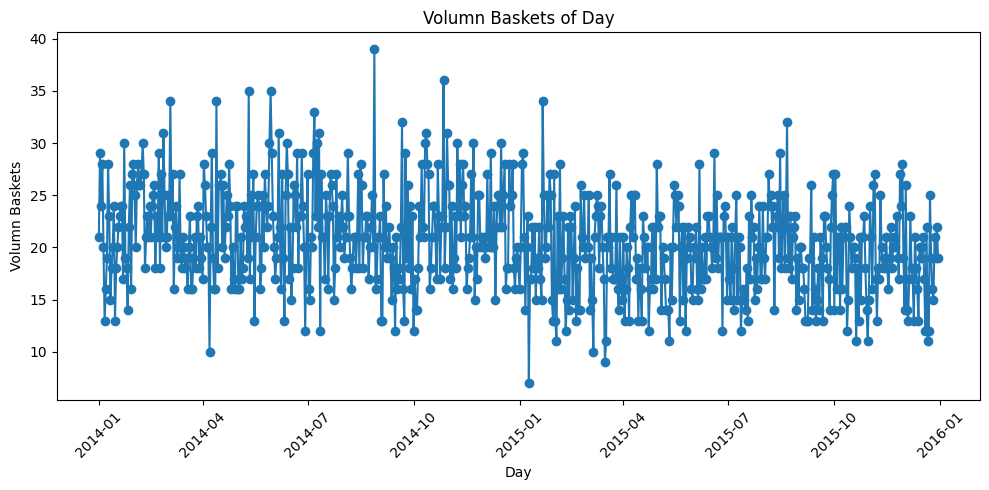

<Figure size 640x480 with 0 Axes>

In [47]:
baskets_count_df = baskets_df.groupBy("Date").count().orderBy("Date")
baskets_count_pd = baskets_count_df.toPandas()
plt.figure(figsize=(10,5))
plt.plot(baskets_count_pd['Date'], baskets_count_pd['count'], marker='o')
plt.title('Volumn Baskets of Day')
plt.xlabel('Day')
plt.ylabel('Volumn Baskets')
plt.xticks(rotation=45)
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()
spark.stop()
plt.close()  # Close the plot to free memory
folder_name = '/content/Baskets'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
plt.savefig(f'{folder_name}/daily_baskets_count.png')

#Task 3#

In [44]:
# Task 3
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("PCY_Alogirthm").getOrCreate()

import itertools
from functools import reduce
import operator
import array
from pyspark.sql.types import BooleanType
from pyspark.sql.functions import explode,split,concat_ws, lit,col,row_number,udf,concat
from pyspark.sql.types import ArrayType,StringType,IntegerType,StructType,StructField
from pyspark.sql.window import Window
from pyspark.sql import SparkSession, Row

class PCY:
  file_path = ""
  s = 0
  c = 0
  number_to_items = {}
  number_of_buckets  = 0

  # contructor function to set up the file_path , support and confident
  def __init__(self, file_path: str, s: float, c: float) -> None:

    self.file_path = file_path
    self.number_of_buckets  = 0
    self.number_to_items = {}
    if 0 <= s <= 1:
        self.s = s
    else:
        raise ValueError("Support s must be in the range from 0 to 1.")
    if 0 <= c <= 1:
        self.c = c
    else:
        raise ValueError("Confidence c must be in the range from 0 to 1.")

  # read CSV file int a df_baskets
  def read_baskets_csv(self) :
    # Read the CSV file
    df_baskets  = spark.read.options(delimiter=",", header=True)\
                       .csv(self.file_path)

    # Select the 'BasketItems' column and split the items
    df_baskets = df_baskets.select("Basket").withColumn("Basket", \
                                            split(df_baskets["Basket"], ","))
    self.s =  self.s * df_baskets.count()
    print("Support is ", self.s)
    print("confident is ", self.c)

    # Explode the 'BasketItems' column to create a new row for each item
    distinct_items = df_baskets.select(explode(df_baskets["Basket"])\
                                .alias("items")).distinct()

    # Create a window ordered by the 'item' column
    window = Window.orderBy("items")

    # Add an index column to the DataFrame using the window
    df_number_items = distinct_items.withColumn("index", row_number()\
                                    .over(window))

    self.number_to_items = df_number_items.rdd \
                                          .map(lambda row: (row[1], row[0]))\
                                          .collectAsMap()
    self.number_of_buckets =df_baskets.count()


    items_to_number = {v: k for k, v in self.number_to_items.items()}
    # Convert string word to number for better hashing
    map_items_udf =udf(lambda items: [items_to_number[item] for item in items]\
                                                    , ArrayType(IntegerType()))

    df_baskets = df_baskets.withColumn('Basket',\
                                       map_items_udf(df_baskets['Basket']))
    return  df_baskets



  # find frequence items
  def f03(self, df_baskets) -> dict():
    # Define UDFs and schemas
    number_of_buckets = self.number_of_buckets
    schema = ArrayType(StructType([StructField("_1", IntegerType(), True),\
  StructField("_2", IntegerType(), True)]))

    # UDF to generate combinations of items in baskets
    combinations_udf = udf(lambda items: [sorted(tuple(comb)) \
                          for comb in itertools.combinations(items, 2)], schema)
    # UDF to hash basket combinations
    hashed_udf = udf(lambda item: reduce(operator.mul, item) \
                                  % number_of_buckets, IntegerType())

    # Pass 1: Count frequency of individual items and filter frequent items
    df_count_items = df_baskets.select(explode(df_baskets["Basket"])\
                              .alias("items")) \
                              .groupBy('items') \
                              .count()

    # Create basket combinations and hash them
    df_basket_combination = df_baskets.withColumn('BasketComb', \
                                       combinations_udf(df_baskets['Basket']))\
                                      .drop('Basket') \
                                      .select(explode(col('BasketComb'))\
                                      .alias("BasketComb")).cache()

    df_hashtable = df_basket_combination.withColumn('HashedBasket', \
                                       hashed_udf(col('BasketComb'))) \
                                      .select("HashedBasket") \
                                      .groupBy("HashedBasket") \
                                      .count()

    # Create a dictionary of single-frequency items
    dict_singfrequence_items={row['items']:row['freq'] for row in df_count_items\
                              .filter(col('count') >= self.s) \
                              .withColumnRenamed('count', 'freq').collect()}

    # Second pass: Create a bitmap to filter frequent pairs
    bitmap = array.array("B", [0 for _ in range(self.number_of_buckets)])
    for row in df_hashtable.collect():
        bitmap[row['HashedBasket']] = 0 if row['count'] < self.s else 1

    keys = list(dict_singfrequence_items.keys())

    # UDF to check if basket combination is frequent based on bitmap
    check_bitmap_udf = udf(lambda items: bitmap[reduce(operator.mul, items) \
                           % number_of_buckets] == 1, BooleanType())

    # Apply the UDF in the filter condition to get frequent basket combinations
    df_filtered = df_basket_combination.filter(
        (col('BasketComb._1').isin(keys) & col('BasketComb._2').isin(keys)) &
        check_bitmap_udf(col('BasketComb'))
    )

    # Create a dictionary of frequent pairs
    dict_pairsfrequence_items = df_filtered.groupby('BasketComb')\
                                            .count()\
                                            .filter(col("count") > self.s)\
                                            .rdd \
                                            .map(lambda row: ((row['BasketComb']['_1'], \
                                                               row['BasketComb']['_2']), \
    row['count']))\
                                            .collectAsMap()

    # Get unique keys from frequent pairs
    unique_key = set([item for key in dict_pairsfrequence_items.keys() for item in key])

    # Filter single-frequency items based on unique keys
    dict_singfrequence_items = {k: v for k, v in dict_singfrequence_items\
                                                 .items() if k in unique_key}

    # Merge dictionaries of frequent pairs and single-frequency items
    dict_frequence_items = {**dict_pairsfrequence_items,**dict_singfrequence_items}
    if len(dict_frequence_items) == 0:
      print("There are no frequent pairs")
      return {}
    # Map dictionary keys to original item names
    mapped_dict = {("[" + ",".join([self.number_to_items[i] for i in key]) + "]" \
                    if isinstance(key, tuple) else self.number_to_items[key]): \
                   v for key, v in dict_frequence_items.items()}

    # Convert dictionary to DataFrame
    df_frequence_items = spark.createDataFrame(list(mapped_dict.items()), \
                                              ["items", "freq"])

    # Write DataFrame to CSV
    df_frequence_items.show()
    frequence_items_pd=df_frequence_items.toPandas()

    frequence_items_pd.to_csv('/content/pcy_frequent_pairs.csv', index = False)

    return dict_frequence_items



  # find association
  def f04(self, dict_frequence_items: dict()) -> None:
    # Filter out the items in dict_frequence_items that are tuples
    if  len(dict_frequence_items) ==0 :
        print("There is no association rule with high confidence.")
        return
    tuple_dict = {k: v for k, v in dict_frequence_items.items() \
                                       if isinstance(k, tuple)}

    # Reverse the tuples in the keys of tuple_dict
    reversed_dict = {(k[1], k[0]): v for k, v in tuple_dict.items()}

    # Combine tuple_dict and reversed_dict into one dictionary
    dict_pair_items = {**tuple_dict, **reversed_dict}

    # Create a list of Rows for the DataFrame
    data = [
        Row(
            antecedent=self.number_to_items[k[0]],  # Antecedent of the rule
            consequent=self.number_to_items[k[1]],  # Consequent of the rule
            confidence=float(v/dict_frequence_items[k[0]]),  # Confidence of the rule
            support=float(v/  self.number_of_buckets) ,  # Frequency of the item pair

        )
        for k, v in dict_pair_items.items()
    ]

    # Create a DataFrame from the list of Rows
    df_associationRules_items = spark.createDataFrame(data)\
                                     .filter(col("confidence") > self.c)
    df_associationRules_items.show()
    if  df_associationRules_items.count() == 0 :
        print("There is no association rule with high confidence.")
        return
    # Write the DataFrame to a CSV file
    associationRules_items_pd=df_associationRules_items.toPandas()
    associationRules_items_pd.to_csv('/content/pcy_association_rules.csv',index = False)


  def run(self) -> None:

    # Read baskets data from CSV
    df_baskets = self.read_baskets_csv()
    # Find frequent_items
    dict_frequence_items = self.f03(df_baskets)
    # Find associationRules
    self.f04(dict_frequence_items)




file_path='/content/Baskets/result.csv'
support = 0.3 # The percentage of items in the basket
confident =  0.5  #the percentage of confident an items is
pcy = PCY(file_path,  support  , confident)


pcy.run()


# Stop the Spark session
spark.stop()

Support is  4488.9
confident is  0.5
There are no frequent pairs
There is no association rule with high confidence.
